In [1]:
import numpy as np
import pandas as pd

# Pretty plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

In [2]:
def timedelta2hours(td):
    return td.days * 24 + td.seconds / 3600

### Load dummy data

In [3]:
# # Load combined data
# results = pd.read_csv('../data/dummy_data_combined.csv')
# # Convert time to datetime
# results.charttime = pd.to_datetime(results.charttime)
# results.intime = pd.to_datetime(results.intime)
# # Sort dataframe by stay id, item id and chart time
# results.sort_values(by=['stay_id', 'itemid', 'charttime'], inplace=True)
# # Reset index
# results.reset_index(drop=True, inplace=True)

# print(results.shape)
# results.head()

In [4]:
# # Load admission data
# adm = pd.read_csv('../data/dummy_admissions.csv')
# # Convert time to datetime
# adm.intime = pd.to_datetime(adm.intime)
# # Sort dataframe by stay id
# adm.sort_values(by='stay_id', inplace=True)
# # Reset index
# adm.reset_index(drop=True, inplace=True)

# print(adm.shape)
# adm.head()

### Load real data

In [5]:
# Load data
df = pd.read_csv('../data/dataset_datathon_21_v2.csv')
df.shape

(1858203, 5)

In [6]:
# Covert timestamps to datetime
df.charttime = pd.to_datetime(df.charttime)
df.intime = pd.to_datetime(df.intime)

# Exclude event later than 72h from admission
df = df[(df.charttime - df.intime).apply(timedelta2hours) <= 72.0]

In [7]:
# Information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906336 entries, 0 to 1857916
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   stay_id      906336 non-null  int64         
 1   intime       906336 non-null  datetime64[ns]
 2   charttime    906336 non-null  datetime64[ns]
 3   event        906336 non-null  object        
 4   event_value  906336 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 41.5+ MB


In [8]:
# Check if any events are missing
df.event.value_counts(dropna=False)

sofa          609716
creatinine     61010
baseexcess     36538
ph             36538
ptt            30797
pt             30280
inr            30279
lactate        24813
ast            18908
alt            18627
albumin         8830
Name: event, dtype: int64

In [9]:
# Convert event type to numeric value
df['event_id'] = df.event.astype('category').cat.codes

# Sort the dataframe 
df.sort_values(by=['stay_id', 'event_id', 'charttime'], inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.head()

(906336, 6)


,stay_id,intime,charttime,event,event_value,event_id
0,30000213,2162-06-21 05:38:00,2162-06-22 04:00:00,alt,12.0,1
1,30000213,2162-06-21 05:38:00,2162-06-22 04:00:00,ast,19.0,2
2,30000213,2162-06-21 05:38:00,2162-06-21 08:27:00,baseexcess,0.0,3
3,30000213,2162-06-21 05:38:00,2162-06-21 14:13:00,baseexcess,1.0,3
4,30000213,2162-06-21 05:38:00,2162-06-21 14:02:00,creatinine,3.7,4


___
# Data checks

In [10]:
# Make sure that intime is always before charttime
assert (df.intime <= df.charttime).all()

In [11]:
(df.intime > df.charttime).sum()

0

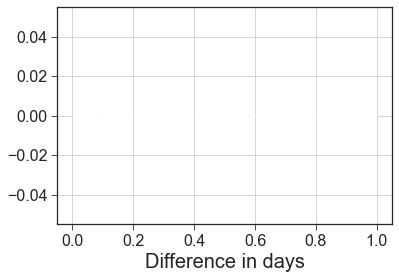

In [12]:
(df[df.intime > df.charttime].intime - df[df.intime > df.charttime].charttime).dt.days.hist();
plt.xlabel('Difference in days');

In [13]:
# Exclude events with negative offset
df = df[df.intime <= df.charttime]
df.reset_index(drop=True, inplace=True)

In [14]:
df

,stay_id,intime,charttime,event,event_value,event_id
0,30000213,2162-06-21 05:38:00,2162-06-22 04:00:00,alt,12.0,1
1,30000213,2162-06-21 05:38:00,2162-06-22 04:00:00,ast,19.0,2
2,30000213,2162-06-21 05:38:00,2162-06-21 08:27:00,baseexcess,0.0,3
3,30000213,2162-06-21 05:38:00,2162-06-21 14:13:00,baseexcess,1.0,3
4,30000213,2162-06-21 05:38:00,2162-06-21 14:02:00,creatinine,3.7,4
...,...,...,...,...,...,...
906331,39998622,2135-02-11 18:13:55,2135-02-14 14:00:00,sofa,3.0,10
906332,39998622,2135-02-11 18:13:55,2135-02-14 15:00:00,sofa,3.0,10
906333,39998622,2135-02-11 18:13:55,2135-02-14 16:00:00,sofa,3.0,10
906334,39998622,2135-02-11 18:13:55,2135-02-14 17:00:00,sofa,3.0,10


In [15]:
# Make sure that there is a single intime for each ICU stay
assert (df.groupby('stay_id').intime.nunique() == 1).all()

___
# Offset `charttime` by `intime`

In [16]:
df['event_time'] = (df.charttime - df.intime).apply(timedelta2hours)

___
# Calculate $\Delta t$

In [18]:
# Calculate the time difference between two subsequent tests for each variable
df['delta_t'] = df.groupby(['stay_id', 'event_id']).event_time.diff()
# df.delta_t = df.delta_t.apply(timedelta2hours)
df.delta_t

0              NaN
1              NaN
2              NaN
3         5.766667
4              NaN
            ...   
906331    1.000000
906332    1.000000
906333    1.000000
906334    1.000000
906335    1.000000
Name: delta_t, Length: 906336, dtype: float64

In [19]:
# Calculate the time difference between the ICU admission and the first test for each var
def calculate_first_diff(x):
    return timedelta2hours(x.charttime)

df.loc[df.delta_t.isna(), 'delta_t'] = df[df.delta_t.isna()].event_time    

In [20]:
df.delta_t.isna().sum()

0

In [21]:
(df.delta_t < 0).sum()

0

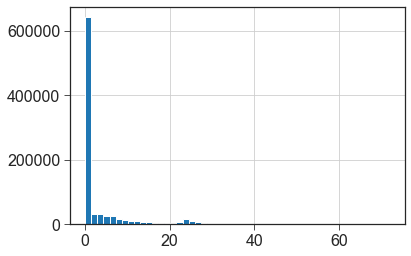

In [22]:
df.delta_t.hist(bins=50);

In [24]:
df.to_csv("../data/dataset_datathon_21_cleaned.csv", index=False)

___
# Splitting data into K folds

In [ ]:
from sklearn.model_selection import train_test_split, KFold

cv = KFold(n_splits=5)

for train, test in cv.split(df.stay_id.unique()):
    print(train.shape, test.shape)



train_id, test_id = train_test_split(df.stay_id.unique())
train_id.shape, test_id.shape

___
# Convert to GRU format
For each stay_id we create a table with itemid.nunique() rows and

In [ ]:
df[df.stay_id==30000213]